In [1]:
import pandas as pd
import pickle as pk
import numpy as np
import matplotlib.pyplot as plt
import itertools as it
import networkx as nx
from collections import (defaultdict,Counter)

In [2]:
#Let's import the chemical-gene interactions from CTD (downloaded on 5th April 2021)
chem_gene_df = pd.read_csv("input/CTD/CTD_chem_gene_ixns.tsv",delimiter= '\t', skipinitialspace=True)
#Here, we filter for only the interactions that regards the H. Sapiens
chem_homo = chem_gene_df[(chem_gene_df['Organism'] == 'Homo sapiens')]

In [3]:
#This cells create a dictionary where each key is a chemical compound and the correspondent value is a genelist 
chem_gene = {}
for i,v in chem_homo.iterrows():
    try:
        chem_gene[v["ChemicalID"]] |= {v["GeneSymbol"]}
    except KeyError as e:
        chem_gene[v["ChemicalID"]] = set([v["GeneSymbol"]])

In [4]:
#Here, we keep only the exposures which perturb at least one gene
chem_gene_cleaned = {}
tot_gene_list=[]
for k,v in chem_gene.items():
    if len(v)>0:
        chem_gene_cleaned[k]=v
        for gene in v:
            tot_gene_list.append(gene)
    else:
        pass


In [5]:
#Let's import the EEN backbone network
backbone_ss_exposure_network = nx.read_weighted_edgelist("output/backbone_exp_graph_significant_weighted.edgelist")

In [6]:
#Let's import the resnik score
with open('intermediate/parenthood_similarity_score_pairs_dictio.pickle', 'rb') as handle:
    parenthood_similarity_score_pairs_dictio = pk.load(handle)
with open('intermediate/wo_parentalhood_resnik.pickle', 'rb') as handle:
    wo_parenthood_similarity_score_pairs_dictio = pk.load(handle)

In [7]:
#Let's merge the resnik score without and with parenthood relationships
tot_resnik={**wo_parenthood_similarity_score_pairs_dictio, **parenthood_similarity_score_pairs_dictio}

In [8]:
#Let's import the genetic overlap JI
    
with open('intermediate/parenthood_overlap_pairs_dictio.pickle', 'rb') as handle:
    parenthood_overlap_pairs_dictio = pk.load(handle)
    
with open('intermediate/wo_parentalhood_gene_overlap.pickle', 'rb') as handle:
    wo_parenthood_overlap_pairs_dictio = pk.load(handle)

    

In [9]:
#Let's merge them together

tot_overlap={**wo_parenthood_overlap_pairs_dictio, **parenthood_overlap_pairs_dictio}

In [10]:
#Let's import the Louvain communities

with open('output/Communities/Louvain/weighted_ji_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)
with open('output/Communities/Louvain/weighted_ji_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)
with open('output/Communities/Louvain/weighted_ji_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)
    


In [12]:
#Here, we are evaluating the resnik score across exposures for the finest level of hierarchy in louvain
#distinguishing the exposures that are part of the same community and those ones that are not part
fine_grained_communities_resnik={}

for com,exp_list in fine_grained_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            fine_grained_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


            
middle_communities_resnik={}

for com,exp_list in middle_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            middle_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


broad_communities_resnik={}

for com,exp_list in broad_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            broad_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


[None]

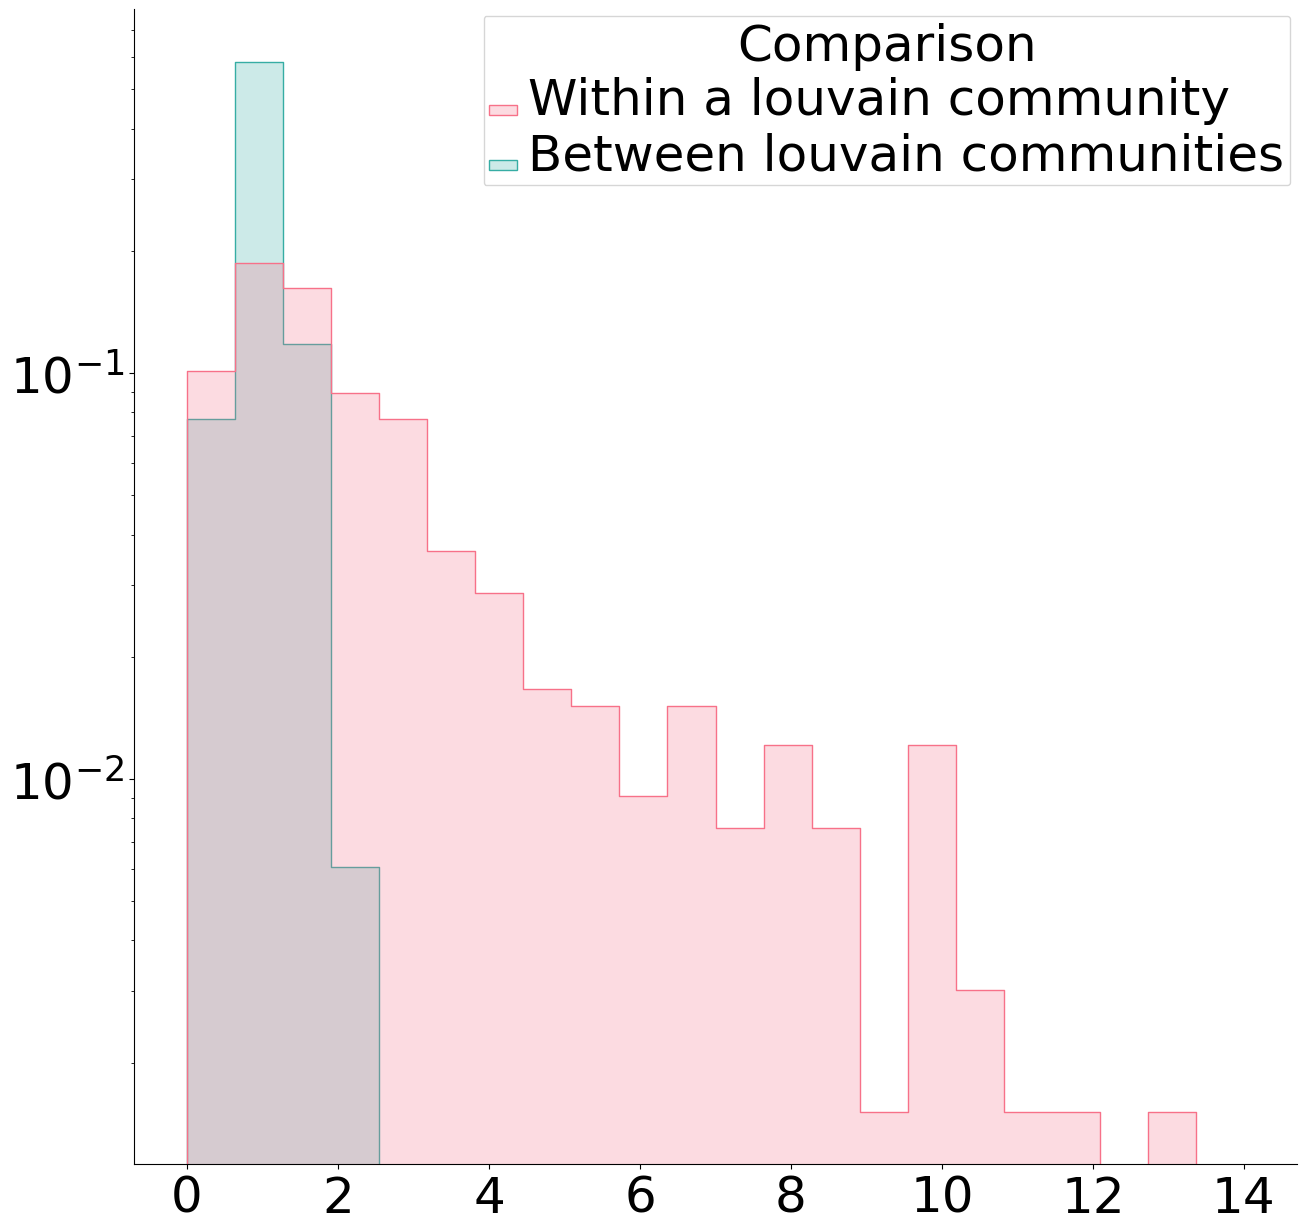

In [13]:
import seaborn as sns

tot_communities_resnik = {**fine_grained_communities_resnik,**middle_communities_resnik, **broad_communities_resnik}

avg_resnik_in_louvain=[]
avg_resnik_out_louvain=[]

for com,res_list in tot_communities_resnik.items():
    avg_resnik_in_louvain.append(float(res_list[0]))
    avg_resnik_out_louvain.append(float(res_list[1]))

state_resnik=[]
for i in avg_resnik_in_louvain:
    state_resnik.append("Within a louvain community")
for i in avg_resnik_out_louvain:
    state_resnik.append("Between louvain communities")


tot_com_resnik_in_out_df=pd.DataFrame()

tot_com_resnik_in_out_df['Resnik']=avg_resnik_in_louvain+avg_resnik_out_louvain

tot_com_resnik_in_out_df['Comparison']=state_resnik


fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.xlabel('Resnik',fontsize=18)
#plt.ylabel('Frequency', fontsize=18)

#plt.title('Resnik distribution of total genes in each hierarchical level of clustering of EEN', fontsize=28)
g=sns.histplot(
    tot_com_resnik_in_out_df, x="Resnik", hue="Comparison", element="step",palette='husl',
    stat="density",bins=22,binrange=(0,14)
)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

g.set(xlabel=None)
g.set(ylabel=None)
g.set(yscale="log")
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
#plt.savefig('output/Figures/Fig2F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight", transparent=True)


In [40]:

# -----------------------------
# rebuild dataframe exactly as plotted
# -----------------------------
tot_communities_resnik = {
    **fine_grained_communities_resnik,
    **middle_communities_resnik,
    **broad_communities_resnik
}

avg_resnik_in_louvain = []
avg_resnik_out_louvain = []

for com, res_list in tot_communities_resnik.items():
    avg_resnik_in_louvain.append(float(res_list[0]))
    avg_resnik_out_louvain.append(float(res_list[1]))

state_resnik = (
    ["Within a louvain community"] * len(avg_resnik_in_louvain) +
    ["Between louvain communities"] * len(avg_resnik_out_louvain)
)

resnik_all = avg_resnik_in_louvain + avg_resnik_out_louvain

tot_com_resnik_in_out_df = pd.DataFrame({
    "Resnik": resnik_all,
    "Comparison": state_resnik
})

# -----------------------------
# histogram summary (same params as plot)
# -----------------------------
bins = 22
binrange = (0, 14)
edges = np.linspace(binrange[0], binrange[1], bins + 1)

summary_rows = []

for group, sub in tot_com_resnik_in_out_df.groupby("Comparison"):

    counts, _ = np.histogram(sub["Resnik"], bins=edges)
    densities = counts / (counts.sum() * np.diff(edges))

    for i in range(len(counts)):
        summary_rows.append({
            "row_type": "hist_summary",
            "Comparison": group,
            "bin_left": edges[i],
            "bin_right": edges[i+1],
            "count": int(counts[i]),
            "density": float(densities[i]),
            "bins": bins,
            "bin_min": binrange[0],
            "bin_max": binrange[1]
        })

summary_df = pd.DataFrame(summary_rows)

# -----------------------------
# raw points table
# -----------------------------
points_df = tot_com_resnik_in_out_df.copy()
points_df["row_type"] = "point"

# align columns
for col in summary_df.columns:
    if col not in points_df.columns:
        points_df[col] = None

for col in points_df.columns:
    if col not in summary_df.columns:
        summary_df[col] = None

source_df = pd.concat([points_df, summary_df], ignore_index=True)

# -----------------------------
# SAFE APPEND TO EXCEL
# -----------------------------
out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
    out_file,
    engine="openpyxl",
    mode="a",
    if_sheet_exists="new"
) as writer:
    source_df.to_excel(writer, sheet_name="Fig2F", index=False)

print("Resnik histogram source data appended safely.")

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_70406/2092574877.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  source_df = pd.concat([points_df, summary_df], ignore_index=True)


Resnik histogram source data appended safely.


In [15]:
#Let's run the T-test between the two distributions
from scipy import stats
t_value,p_value=stats.ttest_ind(avg_resnik_in_louvain,avg_resnik_out_louvain)
p_value

4.4372801331131024e-38

In [15]:
#Let's calculate the Cohen's d as an effect size
def calculate_ttest_and_effect_size(list1, list2):
    from scipy import stats
    import numpy as np
    t_value, p_value = stats.ttest_ind(list1, list2)

    n1 = len(list1)
    n2 = len(list2)
    dof = n1 + n2 - 2

    mean1 = np.mean(list1)
    mean2 = np.mean(list2)
    var1 = np.var(list1, ddof=1)
    var2 = np.var(list2, ddof=1)

    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / dof
    effect_size = (mean1 - mean2) / np.sqrt(pooled_var)

    return t_value, p_value, effect_size

calculate_ttest_and_effect_size(avg_resnik_in_louvain,avg_resnik_out_louvain)

(13.440485313002581, 4.437280132898129e-38, 0.8343461562649733)

In [21]:

finegrained_avg_resnik_in_out_ratio_louvain=[]
middle_avg_resnik_in_out_ratio_louvain=[]
broad_avg_resnik_in_out_ratio_louvain=[]
state_resnik=[]

for com,res_list in fine_grained_communities_resnik.items():
    finegrained_avg_resnik_in_out_ratio_louvain.append(float(res_list[0]))
    state_resnik.append("Fine-grained")
    
for com,res_list in middle_communities_resnik.items():
    middle_avg_resnik_in_out_ratio_louvain.append(float(res_list[0]))
    state_resnik.append("Intermediate")

for com,res_list in broad_communities_resnik.items():
    broad_avg_resnik_in_out_ratio_louvain.append(float(res_list[0]))
    state_resnik.append("Broad")
    


tot_com_resnik_in_out_df=pd.DataFrame()

tot_com_resnik_in_out_df['Resnik']=finegrained_avg_resnik_in_out_ratio_louvain+middle_avg_resnik_in_out_ratio_louvain +broad_avg_resnik_in_out_ratio_louvain

tot_com_resnik_in_out_df['Comparison']=state_resnik


/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_70406/4083755966.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x=tot_com_resnik_in_out_df["Comparison"], y=tot_com_resnik_in_out_df["Resnik"], palette=['#D8C4C5','#A47179','#7A2D45'], linewidth=5)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_70406/4083755966.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_70406/4083755966.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size=36)


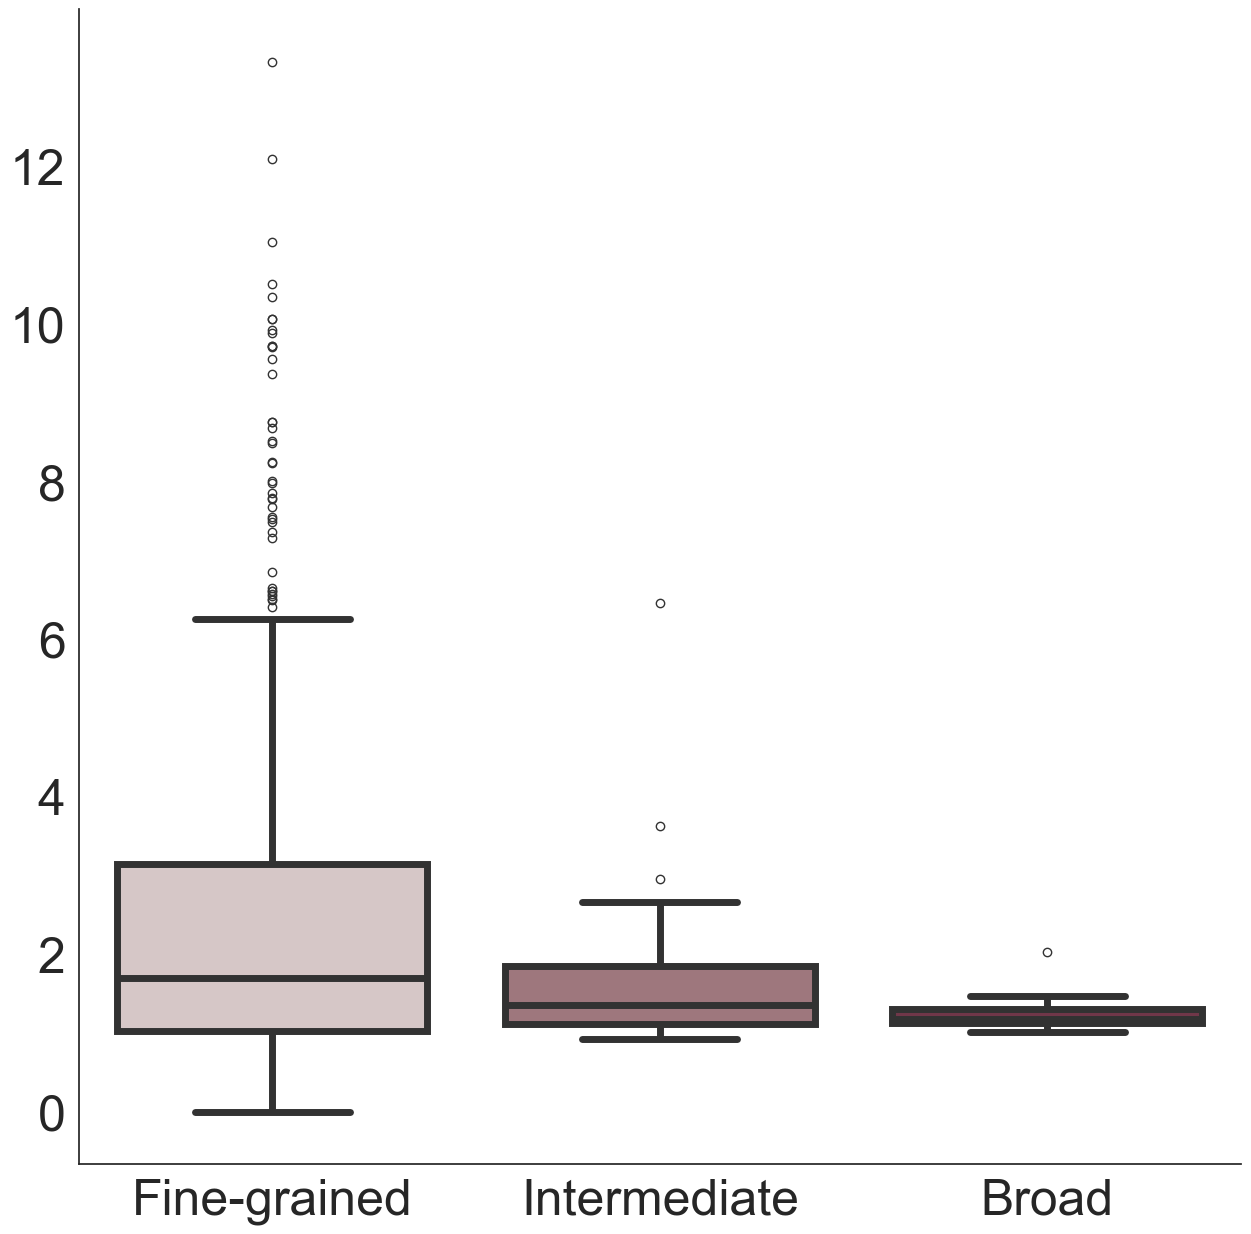

In [37]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.boxplot(x=tot_com_resnik_in_out_df["Comparison"], y=tot_com_resnik_in_out_df["Resnik"], palette=['#D8C4C5','#A47179','#7A2D45'], linewidth=5)

ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
labels = ["Fine-grained", "Intermediate", "Broad"]  # Modified labels
ax.set_xticklabels(labels, size=36)
#plt.savefig('output/Figures/SF5D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [38]:

palette_map = {
    "Fine-grained": "#D8C4C5",
    "Intermediate": "#A47179",
    "Broad": "#7A2D45"
}

tot_com_resnik_in_out_df["Color"] = tot_com_resnik_in_out_df["Comparison"].map(palette_map)

excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    
    tot_com_resnik_in_out_df.to_excel(
        writer,
        sheet_name="SF8D",
        index=False
    )

print("✔ Boxplot source data saved correctly (single sheet).")

✔ Boxplot source data saved correctly (single sheet).


In [20]:
from scipy import stats



t_value,p_value=stats.ttest_ind(finegrained_avg_resnik_in_out_ratio_louvain,middle_avg_resnik_in_out_ratio_louvain)

p_value

0.013734215551003175

In [21]:
from scipy import stats



t_value,p_value=stats.ttest_ind(finegrained_avg_resnik_in_out_ratio_louvain,broad_avg_resnik_in_out_ratio_louvain)

p_value

0.06846062769180661

In [17]:
def calculate_density_LSD(network, group):
    # Create a subnetwork of the total network
    G_subgraph = network.subgraph(group)
    # Calculate the density of that subnetwork
    density = nx.density(G_subgraph)
    return density


In [23]:
tot_com_dict={**fine_grained_communities_dict,**middle_communities_dict, **broad_communities_dict}


tot_com_resnik_in_out_list=[]
density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
    density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,tot_com_dict[com]))

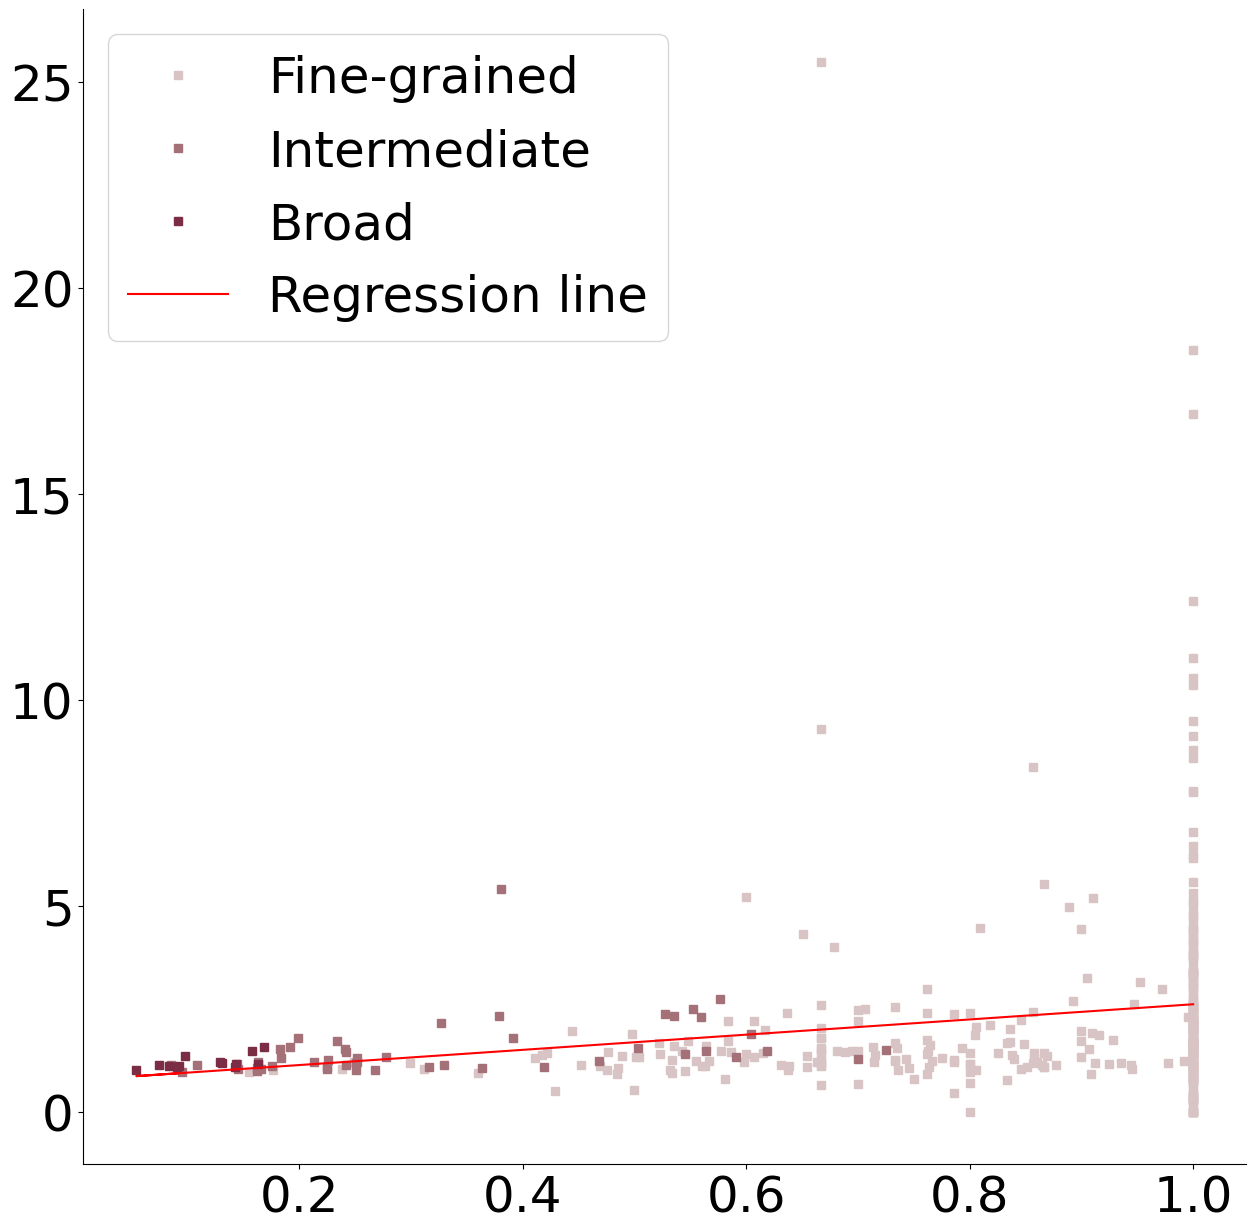

In [18]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats

density_com_list=[]
tot_com_resnik_in_out_list=[]

fine_grained_resnik_in_out_list=[]
fine_grained_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in fine_grained_communities_dict.keys():
        if len(fine_grained_communities_dict[com])>2:
            fine_grained_resnik_in_out_list.append(res_list[0]/res_list[1])
            fine_grained_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))

middle_resnik_in_out_list=[]
middle_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in middle_communities_dict.keys():
        if len(middle_communities_dict[com])>2:
            middle_resnik_in_out_list.append(res_list[0]/res_list[1])
            middle_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
    
broad_resnik_in_out_list=[]
broad_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in broad_communities_dict.keys():
        if len(broad_communities_dict[com])>2:
            broad_resnik_in_out_list.append(res_list[0]/res_list[1])
            broad_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(density_com_list, tot_com_resnik_in_out_list)

ax.plot(fine_grained_density_com_list,fine_grained_resnik_in_out_list, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
ax.plot(middle_density_com_list,middle_resnik_in_out_list, linewidth=0, marker='s',c='#A47179', label='Intermediate')
ax.plot(broad_density_com_list,broad_resnik_in_out_list, linewidth=0, marker='s',c='#7A2D45', label='Broad')

y=[]
for i in density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(density_com_list, y,c='red', label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/SF4B_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [30]:
print(scipy.stats.pearsonr(density_com_list,tot_com_resnik_in_out_list))  # Pearson's r
print(scipy.stats.spearmanr(density_com_list,tot_com_resnik_in_out_list)) # Spearman's rho

PearsonRResult(statistic=0.2166869385555397, pvalue=1.4671558989955178e-05)
SignificanceResult(statistic=0.30858216753015305, pvalue=4.075188496624386e-10)


In [36]:


# Prepare lists for all communities
all_density = fine_grained_density_com_list + middle_density_com_list + broad_density_com_list
all_resnik = fine_grained_resnik_in_out_list + middle_resnik_in_out_list + broad_resnik_in_out_list
all_community_type = (["Fine-grained"]*len(fine_grained_density_com_list) + 
                      ["Intermediate"]*len(middle_density_com_list) + 
                      ["Broad"]*len(broad_density_com_list))
all_colors = (['#D8C4C5']*len(fine_grained_density_com_list) + 
              ['#A47179']*len(middle_density_com_list) + 
              ['#7A2D45']*len(broad_density_com_list))

# Build dataframe
SF7B_source_df = pd.DataFrame({
    "Density": all_density,
    "Resnik_in_out": all_resnik,
    "Community_type": all_community_type,
    "Color": all_colors
})

# Append to existing Excel file
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    SF7B_source_df.to_excel(writer, sheet_name="SF7B", index=False)

print("Source data for SF7B scatter plot appended successfully.")

Source data for SF7B scatter plot appended successfully.


In [31]:
#Here, we are evaluating the resnik score across exposures for the finest level of hierarchy in louvain
#distinguishing the exposures that are part of the same community and those ones that are not part
fine_grained_communities_overlap={}

for com,exp_list in fine_grained_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            fine_grained_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


            
middle_communities_overlap={}

for com,exp_list in middle_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            middle_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


broad_communities_overlap={}

for com,exp_list in broad_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            broad_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


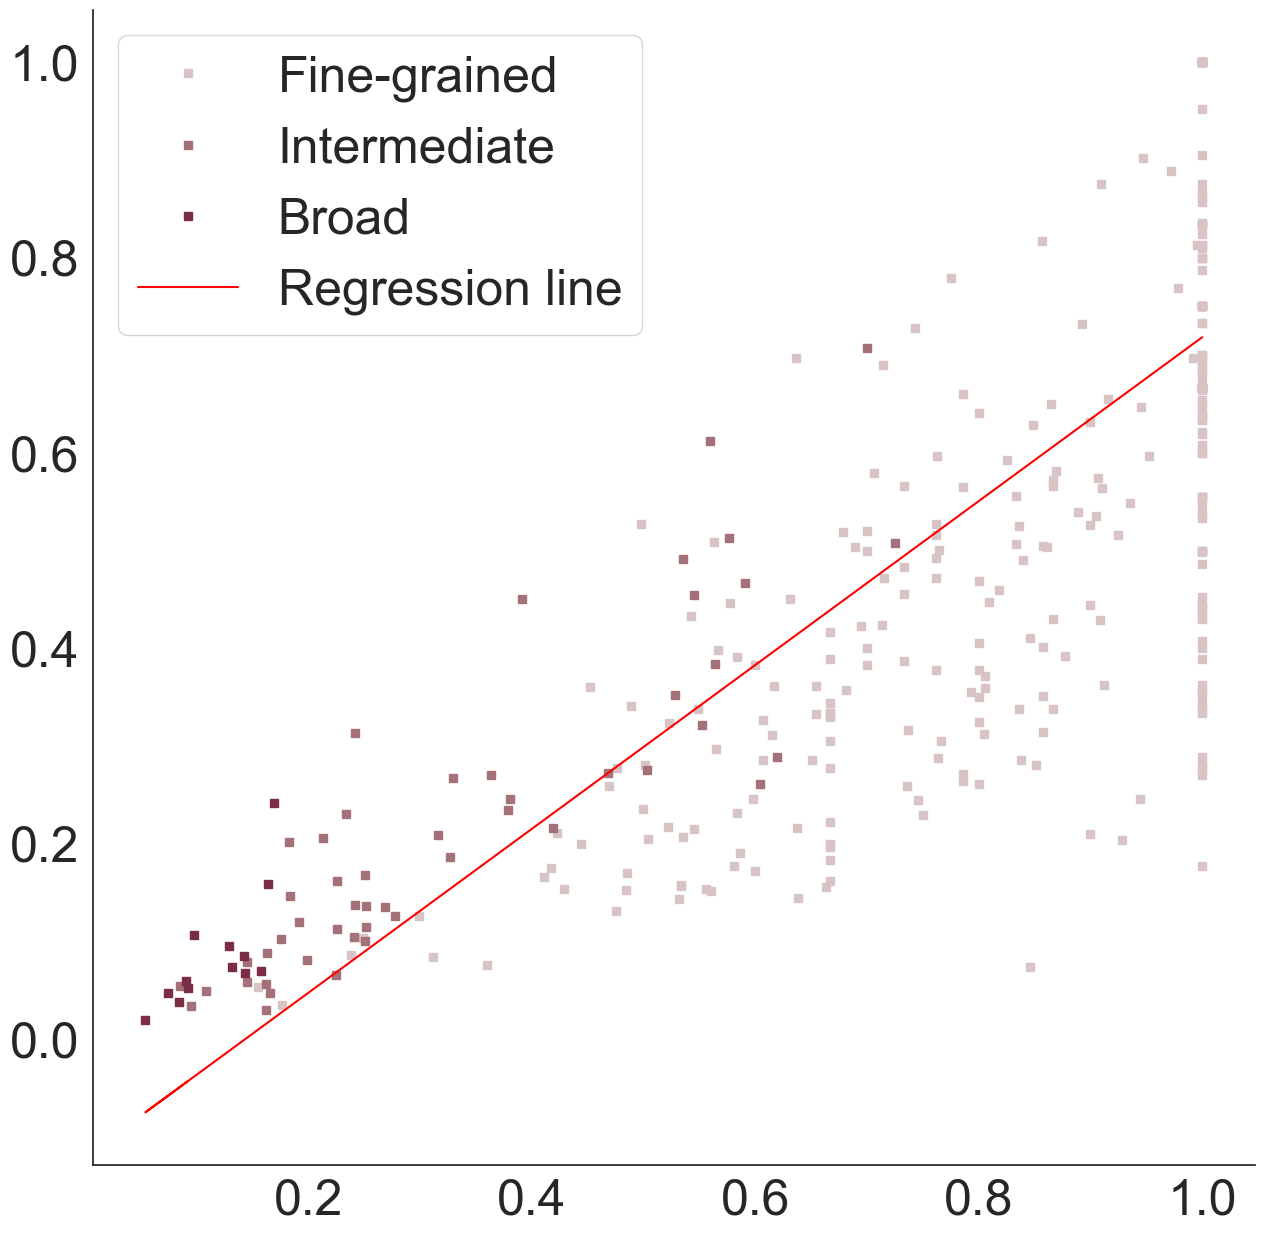

In [32]:
#Let's remove duplets and let's look at network modularity and genetic overlap
import scipy
from matplotlib.pyplot import figure
from scipy import stats

tot_communities_overlap={**fine_grained_communities_overlap,**middle_communities_overlap,**broad_communities_overlap}
density_com_list=[]
tot_com_overlap_in_list=[]

fine_grained_overlap_in_list=[]
fine_grained_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in fine_grained_communities_dict.keys():
        if len(fine_grained_communities_dict[com])>2:
            fine_grained_overlap_in_list.append(res_list[0])
            fine_grained_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))


middle_overlap_in_list=[]
middle_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in middle_communities_dict.keys():
        if len(middle_communities_dict[com])>2:
            middle_overlap_in_list.append(res_list[0])
            middle_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
    
    
broad_overlap_in_list=[]
broad_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in broad_communities_dict.keys():
        if len(broad_communities_dict[com])>2:
            broad_overlap_in_list.append(res_list[0])
            broad_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(density_com_list, tot_com_overlap_in_list)

ax.plot(fine_grained_density_com_list,fine_grained_overlap_in_list, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
ax.plot(middle_density_com_list,middle_overlap_in_list, linewidth=0, marker='s',c='#A47179', label='Intermediate')
ax.plot(broad_density_com_list,broad_overlap_in_list, linewidth=0, marker='s',c='#7A2D45', label='Broad')

y=[]
for i in density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(density_com_list, y,c='red', label=line)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/Figure2C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [ ]:
ax.plot(fine_grained_density_com_list,fine_grained_overlap_in_list, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
ax.plot(middle_density_com_list,middle_overlap_in_list, linewidth=0, marker='s',c='#A47179', label='Intermediate')
ax.plot(broad_density_com_list,broad_overlap_in_list, linewidth=0, marker='s',c='#7A2D45', label='Broad')


In [41]:

# Prepare lists for all communities
all_density = fine_grained_density_com_list + middle_density_com_list + broad_density_com_list
all_genetic_overlap = fine_grained_overlap_in_list + middle_overlap_in_list + broad_overlap_in_list
all_community_type = (["Fine-grained"]*len(fine_grained_density_com_list) + 
                      ["Intermediate"]*len(middle_density_com_list) + 
                      ["Broad"]*len(broad_density_com_list))

all_colors = (['#D8C4C5']*len(fine_grained_density_com_list) + 
              ['#A47179']*len(middle_density_com_list) + 
              ['#7A2D45']*len(broad_density_com_list))

# Build dataframe
Fig2C_source_df = pd.DataFrame({
    "Density": all_density,
    "Genetic Overlap": all_genetic_overlap,
    "Community_type": all_community_type,
    "Color": all_colors
})

# Append to existing Excel file
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    Fig2C_source_df.to_excel(writer, sheet_name="Fig2C", index=False)


In [28]:
print(scipy.stats.pearsonr(density_com_list, tot_com_overlap_in_list))

PearsonRResult(statistic=0.7812088075487331, pvalue=5.0429754454190797e-82)


In [33]:
import scipy
from matplotlib.pyplot import figure
from scipy import stats
#Let's create two lists that will containing the genetic overlap and the resnik values for these communities

avg_overlap_in_com=[]
avg_resnik_in_com=[]
for com,overlap_list in tot_communities_overlap.items():
    avg_overlap_in_com.append(overlap_list[0])
    avg_resnik_in_com.append(tot_communities_resnik[com][0])

column_names = ["Resnik", "Overlap",'Group']

geneoverlap_resnik_df = pd.DataFrame(columns = column_names)
geneoverlap_resnik_df['Resnik']=avg_resnik_in_com
geneoverlap_resnik_df['Overlap']=avg_overlap_in_com


geneoverlap_resnik_df_sort_by_overlap=geneoverlap_resnik_df.sort_values("Overlap")

cat_list=[]
for i in range(len(geneoverlap_resnik_df_sort_by_overlap)):
    if i<len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("1st quintile")
    elif i>len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<2*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<3*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<4*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
geneoverlap_resnik_df_sort_by_overlap["Group"]=cat_list

In [39]:

# Append to your existing SourceData Excel
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    geneoverlap_resnik_df_sort_by_overlap.to_excel(
        writer,
        sheet_name="SF8E",
        index=False
    )



/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_1213/938415392.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=geneoverlap_resnik_df_sort_by_overlap,x="Group", y="Resnik",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_1213/938415392.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 36)


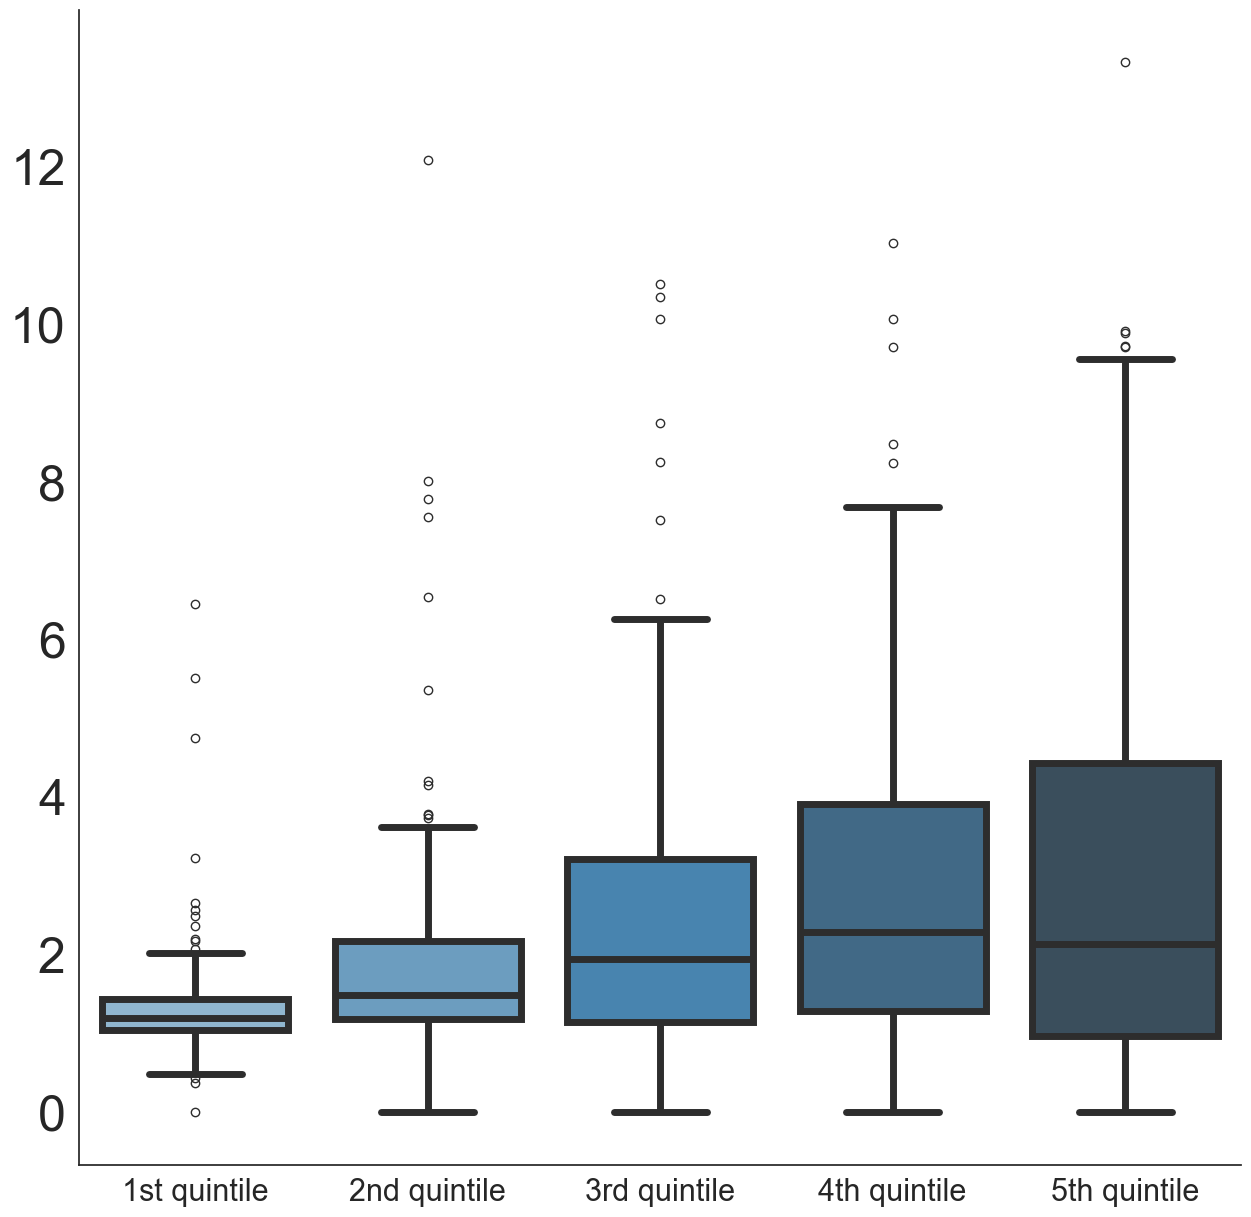

In [33]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=geneoverlap_resnik_df_sort_by_overlap,x="Group", y="Resnik",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],palette="Blues_d",linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
plt.savefig('output/Figures/SF5E_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()


In [34]:
print(scipy.stats.pearsonr(avg_overlap_in_com, avg_resnik_in_com))


PearsonRResult(statistic=0.26913109842228816, pvalue=4.611347212301309e-10)


### Infomap

In [10]:
#Let's import the infomap communities

with open('output/Communities/Infomap/ji_infomap_fine_grained_communities_dict.pickle', 'rb') as handle:
    fine_grained_communities_dict = pk.load(handle)
with open('output/Communities/Infomap/ji_infomap_middle_communities_dict.pickle', 'rb') as handle:
    middle_communities_dict = pk.load(handle)
with open('output/Communities/Infomap/ji_infomap_broad_communities_dict.pickle', 'rb') as handle:
    broad_communities_dict = pk.load(handle)
    


In [11]:
#Here, we are evaluating the resnik score across exposures for the finest level of hierarchy in louvain
#distinguishing the exposures that are part of the same community and those ones that are not part
fine_grained_communities_resnik={}

for com,exp_list in fine_grained_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            fine_grained_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


            
middle_communities_resnik={}

for com,exp_list in middle_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            middle_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


broad_communities_resnik={}

for com,exp_list in broad_communities_dict.items():
    try:
        if len(exp_list)>1:
            resnik_list_in=[]
            resnik_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        resnik_list_in.append(tot_resnik[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            resnik_list_out.append(tot_resnik[exp1,exp2])
                        except:
                            resnik_list_out.append(tot_resnik[exp2,exp1])
                    except:
                        pass
            avg_resnik_in=sum(resnik_list_in)/len(resnik_list_in)
            avg_resnik_out=sum(resnik_list_out)/len(resnik_list_out)
            broad_communities_resnik[com]=[avg_resnik_in,avg_resnik_out]
        else:
            pass
    except:
        pass


[None]

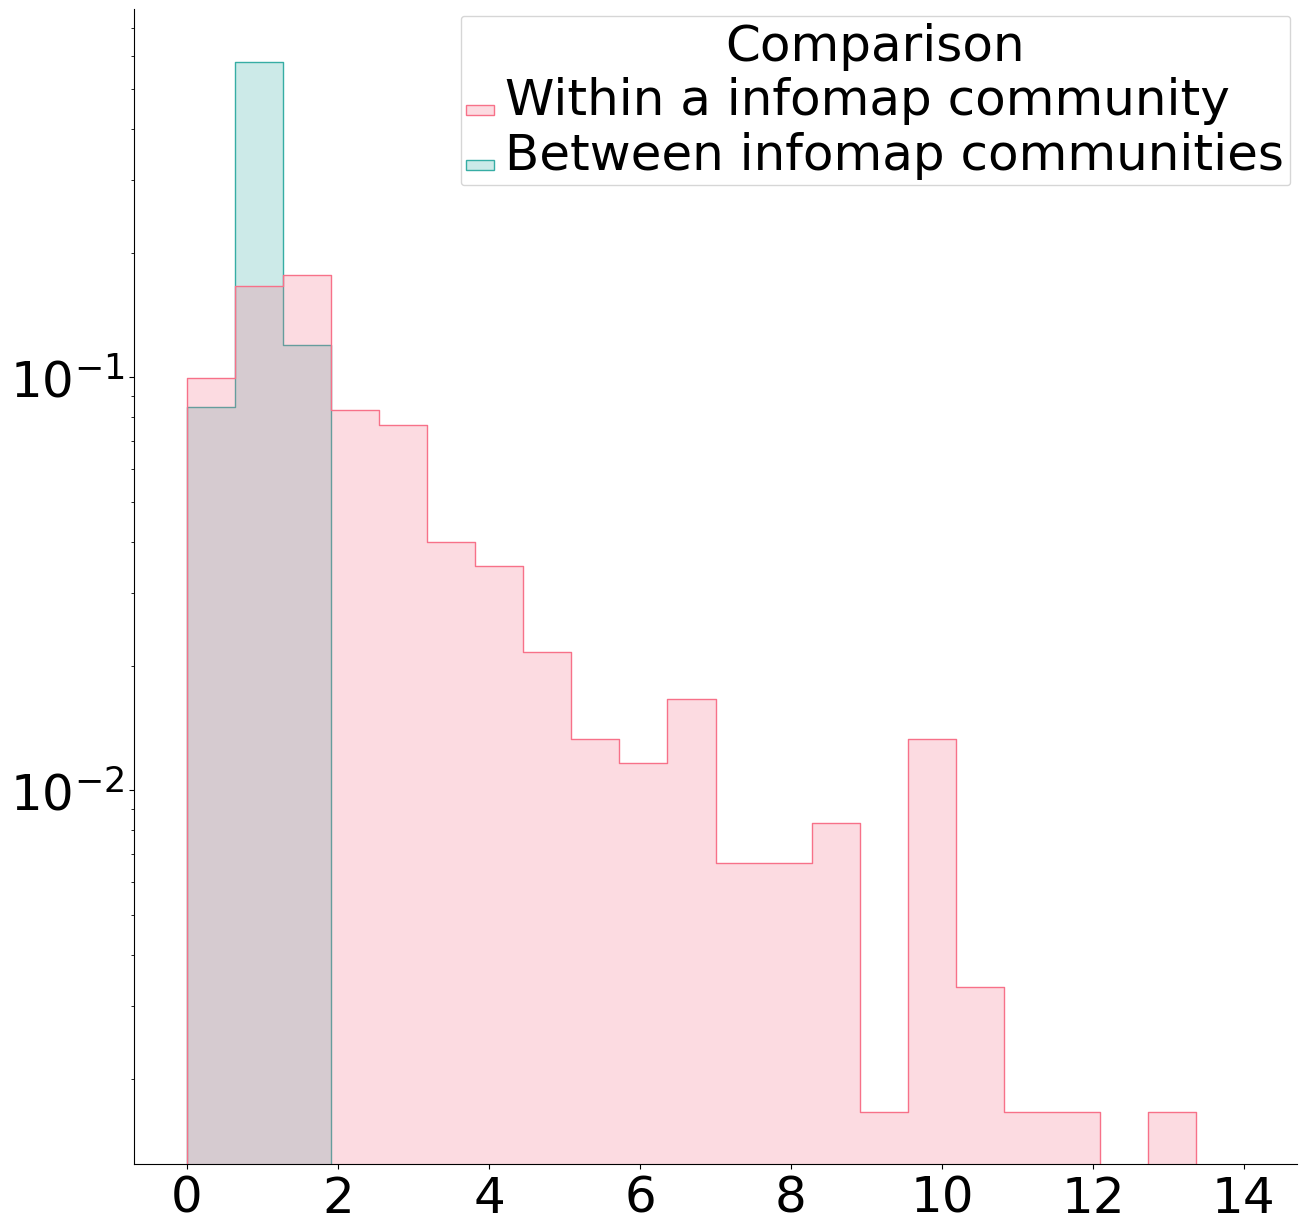

In [13]:
import seaborn as sns

tot_communities_resnik = {**fine_grained_communities_resnik,**middle_communities_resnik, **broad_communities_resnik}

avg_resnik_in_infomap=[]
avg_resnik_out_infomap=[]

for com,res_list in tot_communities_resnik.items():
    avg_resnik_in_infomap.append(float(res_list[0]))
    avg_resnik_out_infomap.append(float(res_list[1]))

state_resnik=[]
for i in avg_resnik_in_infomap:
    state_resnik.append("Within a infomap community")
for i in avg_resnik_out_infomap:
    state_resnik.append("Between infomap communities")


tot_com_resnik_in_out_df=pd.DataFrame()

tot_com_resnik_in_out_df['Resnik']=avg_resnik_in_infomap+avg_resnik_out_infomap

tot_com_resnik_in_out_df['Comparison']=state_resnik


fig, ax = plt.subplots(figsize=(15,15))
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
#plt.xlabel('Resnik',fontsize=18)
#plt.ylabel('Frequency', fontsize=18)

#plt.title('Resnik distribution of total genes in each hierarchical level of clustering of EEN', fontsize=28)
g=sns.histplot(
    tot_com_resnik_in_out_df, x="Resnik", hue="Comparison", element="step",palette='husl',
    stat="density",bins=22,binrange=(0,14)
)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

g.set(xlabel=None)
g.set(ylabel=None)
g.set(yscale="log")
plt.setp(ax.get_legend().get_texts(), fontsize='36') # for legend text
plt.setp(ax.get_legend().get_title(), fontsize='36') # for legend title
#plt.savefig('output/Figures/SF16F_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight", transparent=True)


In [14]:

# -----------------------------
# rebuild dataframe exactly as plotted
# -----------------------------
tot_communities_resnik = {
    **fine_grained_communities_resnik,
    **middle_communities_resnik,
    **broad_communities_resnik
}

avg_resnik_in_infomap = []
avg_resnik_out_infomap = []

for com, res_list in tot_communities_resnik.items():
    avg_resnik_in_infomap.append(float(res_list[0]))
    avg_resnik_out_infomap.append(float(res_list[1]))

state_resnik = (
    ["Within a infomap community"] * len(avg_resnik_in_infomap) +
    ["Between infomap communities"] * len(avg_resnik_out_infomap)
)

resnik_all = avg_resnik_in_infomap + avg_resnik_out_infomap

tot_com_resnik_in_out_df = pd.DataFrame({
    "Resnik": resnik_all,
    "Comparison": state_resnik
})

# -----------------------------
# histogram summary (same params as plot)
# -----------------------------
bins = 22
binrange = (0, 14)
edges = np.linspace(binrange[0], binrange[1], bins + 1)

summary_rows = []

for group, sub in tot_com_resnik_in_out_df.groupby("Comparison"):

    counts, _ = np.histogram(sub["Resnik"], bins=edges)
    densities = counts / (counts.sum() * np.diff(edges))

    for i in range(len(counts)):
        summary_rows.append({
            "row_type": "hist_summary",
            "Comparison": group,
            "bin_left": edges[i],
            "bin_right": edges[i+1],
            "count": int(counts[i]),
            "density": float(densities[i]),
            "bins": bins,
            "bin_min": binrange[0],
            "bin_max": binrange[1]
        })

summary_df = pd.DataFrame(summary_rows)

# -----------------------------
# raw points table
# -----------------------------
points_df = tot_com_resnik_in_out_df.copy()
points_df["row_type"] = "point"

# align columns
for col in summary_df.columns:
    if col not in points_df.columns:
        points_df[col] = None

for col in points_df.columns:
    if col not in summary_df.columns:
        summary_df[col] = None

source_df = pd.concat([points_df, summary_df], ignore_index=True)

# -----------------------------
# SAFE APPEND TO EXCEL
# -----------------------------
out_file = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
    out_file,
    engine="openpyxl",
    mode="a",
    if_sheet_exists="new"
) as writer:
    source_df.to_excel(writer, sheet_name="SF22F", index=False)

print("Resnik histogram source data appended safely.")

/var/folders/rm/nxxl_j315bb0tmsp5x9217hh0000gp/T/ipykernel_79972/1621854013.py:73: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  source_df = pd.concat([points_df, summary_df], ignore_index=True)


Resnik histogram source data appended safely.


In [22]:
#Let's run the T-test between the two distributions
from scipy import stats
t_value,p_value=stats.ttest_ind(avg_resnik_in_infomap,avg_resnik_out_infomap)
p_value

1.7786338440966404e-37

In [23]:
#Let's calculate the Cohen's d as an effect size
def calculate_ttest_and_effect_size(list1, list2):
    from scipy import stats
    import numpy as np
    t_value, p_value = stats.ttest_ind(list1, list2)

    n1 = len(list1)
    n2 = len(list2)
    dof = n1 + n2 - 2

    mean1 = np.mean(list1)
    mean2 = np.mean(list2)
    var1 = np.var(list1, ddof=1)
    var2 = np.var(list2, ddof=1)

    pooled_var = ((n1 - 1) * var1 + (n2 - 1) * var2) / dof
    effect_size = (mean1 - mean2) / np.sqrt(pooled_var)

    return t_value, p_value, effect_size

calculate_ttest_and_effect_size(avg_resnik_in_infomap,avg_resnik_out_infomap)

(13.373879798078871, 1.7786338440966404e-37, 0.8705654232501644)

In [24]:

finegrained_avg_resnik_in_out_ratio_infomap=[]
middle_avg_resnik_in_out_ratio_infomap=[]
broad_avg_resnik_in_out_ratio_infomap=[]
state_resnik=[]

for com,res_list in fine_grained_communities_resnik.items():
    finegrained_avg_resnik_in_out_ratio_infomap.append(float(res_list[0]))
    state_resnik.append("Fine-grained")
    
for com,res_list in middle_communities_resnik.items():
    middle_avg_resnik_in_out_ratio_infomap.append(float(res_list[0]))
    state_resnik.append("Intermediate")

for com,res_list in broad_communities_resnik.items():
    broad_avg_resnik_in_out_ratio_infomap.append(float(res_list[0]))
    state_resnik.append("Broad")
    


tot_com_resnik_in_out_df=pd.DataFrame()

tot_com_resnik_in_out_df['Resnik']=finegrained_avg_resnik_in_out_ratio_infomap+middle_avg_resnik_in_out_ratio_infomap +broad_avg_resnik_in_out_ratio_infomap

tot_com_resnik_in_out_df['Comparison']=state_resnik


/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_34128/3869115118.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(x=tot_com_resnik_in_out_df["Comparison"], y=tot_com_resnik_in_out_df["Resnik"], palette="Blues_d", linewidth=5)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_34128/3869115118.py:15: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_34128/3869115118.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(labels, size=36)


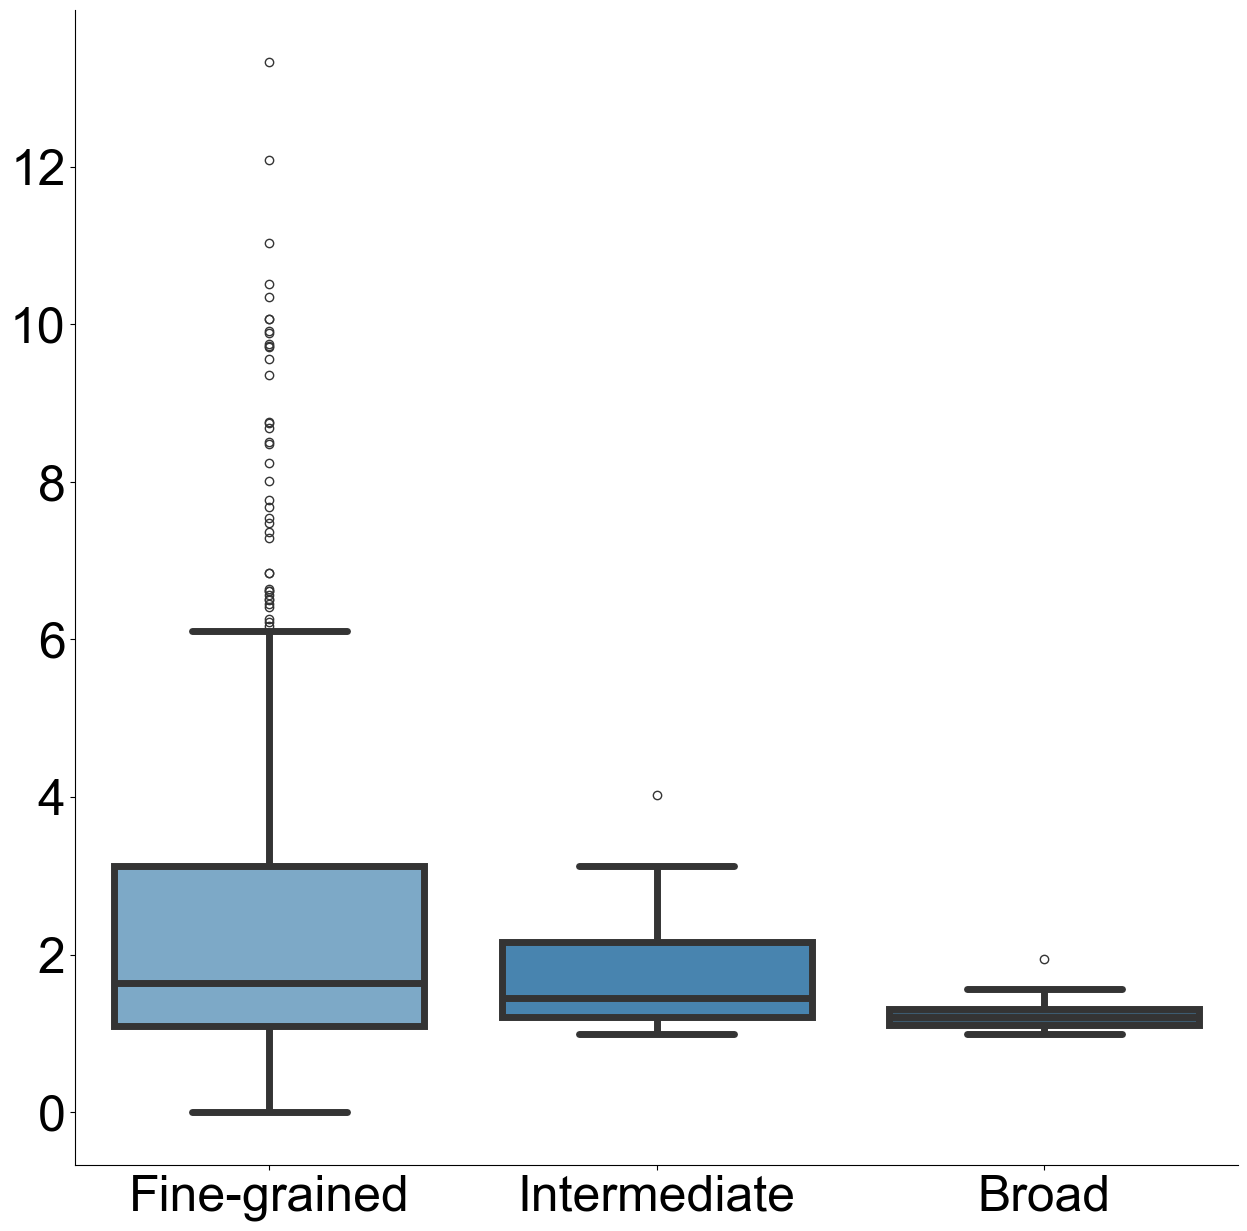

In [25]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(15, 15))
sns.set(style="white")

g=sns.boxplot(x=tot_com_resnik_in_out_df["Comparison"], y=tot_com_resnik_in_out_df["Resnik"], palette="Blues_d", linewidth=5)

ax.set_xlabel("",fontsize=32)
ax.set_ylabel("",fontsize=32)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.set_yticklabels([int(i) for i in list(ax.get_yticks())], size = 36)
labels = ["Fine-grained", "Intermediate", "Broad"]  # Modified labels
ax.set_xticklabels(labels, size=36)
#plt.savefig('output/Figures/SF19A_v00.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [26]:
from scipy import stats



t_value,p_value=stats.ttest_ind(finegrained_avg_resnik_in_out_ratio_infomap,middle_avg_resnik_in_out_ratio_infomap)

p_value

0.17314916713392736

In [27]:
from scipy import stats



t_value,p_value=stats.ttest_ind(finegrained_avg_resnik_in_out_ratio_infomap,broad_avg_resnik_in_out_ratio_infomap)

p_value

0.13230028388877504

In [15]:
def calculate_density_LSD(network, group):
    # Create a subnetwork of the total network
    G_subgraph = network.subgraph(group)
    # Calculate the density of that subnetwork
    density = nx.density(G_subgraph)
    return density


In [16]:
tot_com_dict={**fine_grained_communities_dict,**middle_communities_dict, **broad_communities_dict}


tot_com_resnik_in_out_list=[]
density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
    density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,tot_com_dict[com]))

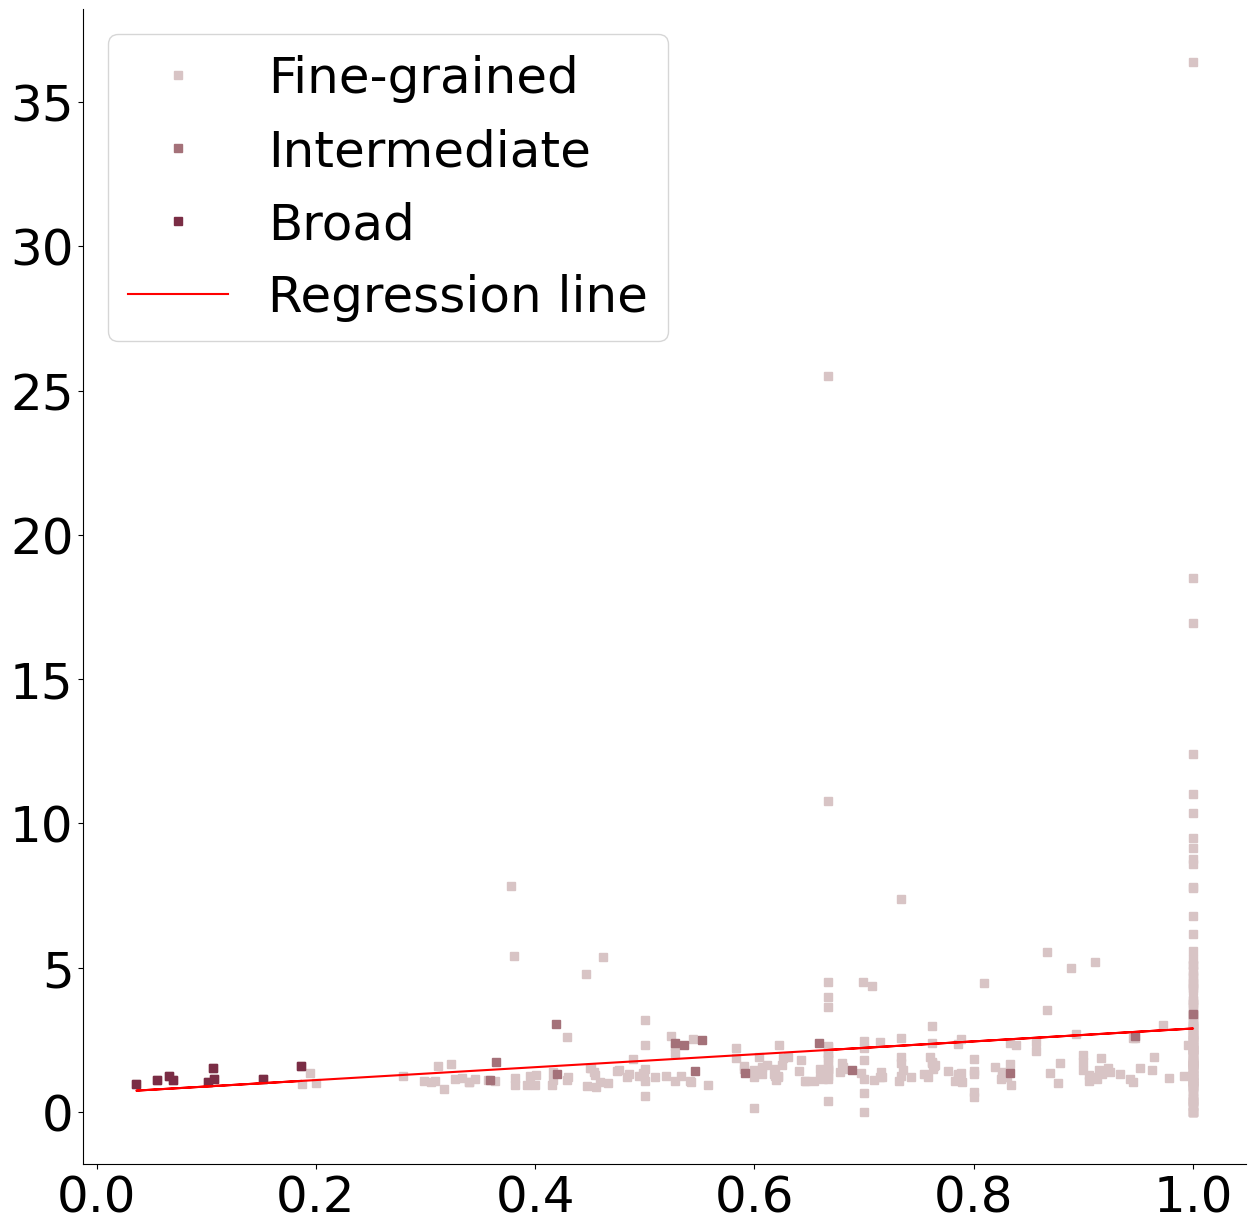

In [17]:
#Let's remove duplets
import scipy
from matplotlib.pyplot import figure
from scipy import stats

density_com_list=[]
tot_com_resnik_in_out_list=[]

fine_grained_resnik_in_out_list=[]
fine_grained_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in fine_grained_communities_dict.keys():
        if len(fine_grained_communities_dict[com])>2:
            fine_grained_resnik_in_out_list.append(res_list[0]/res_list[1])
            fine_grained_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))

middle_resnik_in_out_list=[]
middle_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in middle_communities_dict.keys():
        if len(middle_communities_dict[com])>2:
            middle_resnik_in_out_list.append(res_list[0]/res_list[1])
            middle_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
    
broad_resnik_in_out_list=[]
broad_density_com_list=[]
for com,res_list in tot_communities_resnik.items():
    if com in broad_communities_dict.keys():
        if len(broad_communities_dict[com])>2:
            broad_resnik_in_out_list.append(res_list[0]/res_list[1])
            broad_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
            tot_com_resnik_in_out_list.append(res_list[0]/res_list[1])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(density_com_list, tot_com_resnik_in_out_list)

ax.plot(fine_grained_density_com_list,fine_grained_resnik_in_out_list, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
ax.plot(middle_density_com_list,middle_resnik_in_out_list, linewidth=0, marker='s',c='#A47179', label='Intermediate')
ax.plot(broad_density_com_list,broad_resnik_in_out_list, linewidth=0, marker='s',c='#7A2D45', label='Broad')



y=[]
for i in density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(density_com_list, y,c='red', label=line)
#ax.set_xlabel('Average biological similarity', fontsize=18)
#ax.set_ylabel('Average chemical similarity',fontsize=18)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

# plt.title('Correlation between Resnik and Genetic overlap in %s' %met )
ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/SF16D_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [37]:
print(scipy.stats.pearsonr(density_com_list,tot_com_resnik_in_out_list))  # Pearson's r
print(scipy.stats.spearmanr(density_com_list,tot_com_resnik_in_out_list)) # Spearman's rho

PearsonRResult(statistic=0.19607728678106903, pvalue=0.00015667415057980168)
SignificanceResult(statistic=0.30451658757310196, pvalue=2.587492728580625e-09)


In [18]:


# Prepare lists for all communities
all_density = fine_grained_density_com_list + middle_density_com_list + broad_density_com_list
all_resnik = fine_grained_resnik_in_out_list + middle_resnik_in_out_list + broad_resnik_in_out_list
all_community_type = (["Fine-grained"]*len(fine_grained_density_com_list) + 
                      ["Intermediate"]*len(middle_density_com_list) + 
                      ["Broad"]*len(broad_density_com_list))
all_colors = (['#D8C4C5']*len(fine_grained_density_com_list) + 
              ['#A47179']*len(middle_density_com_list) + 
              ['#7A2D45']*len(broad_density_com_list))

# Build dataframe
SF22D_source_df = pd.DataFrame({
    "Density": all_density,
    "Resnik_in_out": all_resnik,
    "Community_type": all_community_type,
    "Color": all_colors
})

# Append to existing Excel file
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    SF22D_source_df.to_excel(writer, sheet_name="SF22D", index=False)

print("Source data for SF22D scatter plot appended successfully.")

Source data for SF22D scatter plot appended successfully.


In [19]:
#Here, we are evaluating the resnik score across exposures for the finest level of hierarchy in louvain
#distinguishing the exposures that are part of the same community and those ones that are not part
fine_grained_communities_overlap={}

for com,exp_list in fine_grained_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            fine_grained_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


            
middle_communities_overlap={}

for com,exp_list in middle_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            middle_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


broad_communities_overlap={}

for com,exp_list in broad_communities_dict.items():
    try:
        if len(exp_list)>1:
            overlap_list_in=[]
            overlap_list_out=[]
            pairwise_list = list(it.combinations(exp_list, 2))
            for i in range(len(pairwise_list)):
                try:
                    try:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][0],pairwise_list[i][1]])
                    except:
                        overlap_list_in.append(tot_overlap[pairwise_list[i][1],pairwise_list[i][0]])
                except:
                    pass
            not_exp_com_list=[]
            for exp in backbone_ss_exposure_network.nodes():
                if exp not in exp_list:
                    not_exp_com_list.append(exp)
                else:
                    pass
            for exp1 in exp_list:
                for exp2 in not_exp_com_list:
                    try:
                        try:
                            overlap_list_out.append(tot_overlap[exp1,exp2])
                        except:
                            overlap_list_out.append(tot_overlap[exp2,exp1])
                    except:
                        pass
            avg_overlap_in=sum(overlap_list_in)/len(overlap_list_in)
            avg_overlap_out=sum(overlap_list_out)/len(overlap_list_out)
            broad_communities_overlap[com]=[avg_overlap_in,avg_overlap_out]
        else:
            pass
    except:
        pass


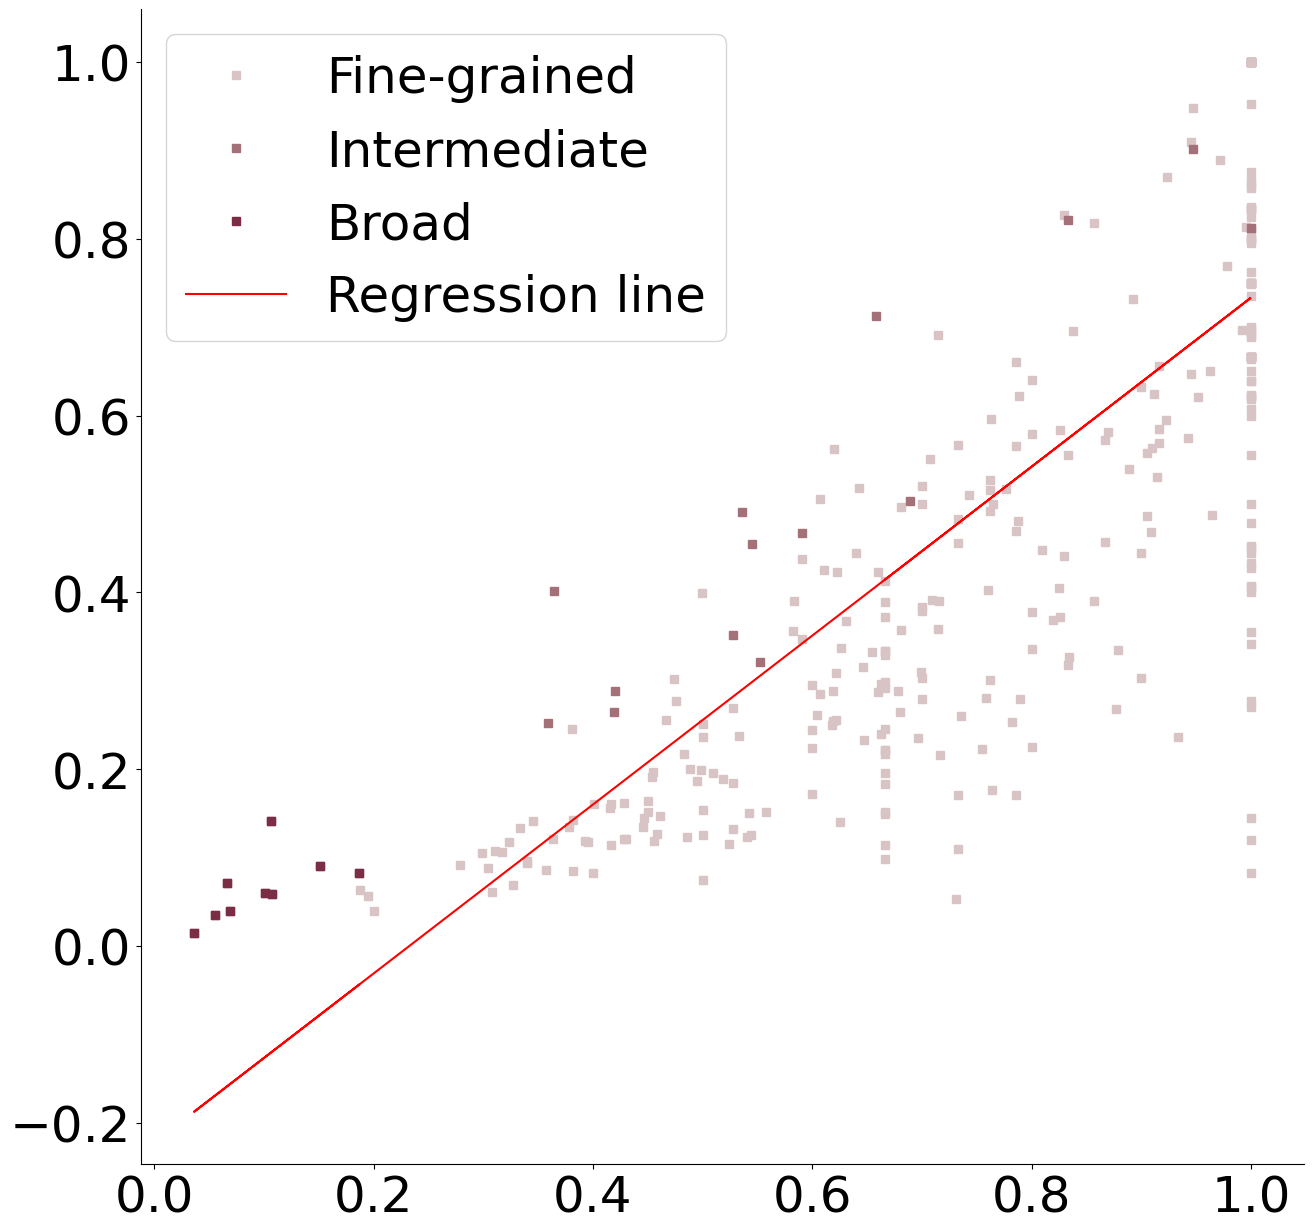

In [20]:
#Let's remove duplets and let's look at network modularity and genetic overlap
import scipy
from matplotlib.pyplot import figure
from scipy import stats

tot_communities_overlap={**fine_grained_communities_overlap,**middle_communities_overlap,**broad_communities_overlap}
density_com_list=[]
tot_com_overlap_in_list=[]

fine_grained_overlap_in_list=[]
fine_grained_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in fine_grained_communities_dict.keys():
        if len(fine_grained_communities_dict[com])>2:
            fine_grained_overlap_in_list.append(res_list[0])
            fine_grained_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,fine_grained_communities_dict[com]))


middle_overlap_in_list=[]
middle_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in middle_communities_dict.keys():
        if len(middle_communities_dict[com])>2:
            middle_overlap_in_list.append(res_list[0])
            middle_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,middle_communities_dict[com])) 
    
    
broad_overlap_in_list=[]
broad_density_com_list=[]
for com,res_list in tot_communities_overlap.items():
    if com in broad_communities_dict.keys():
        if len(broad_communities_dict[com])>2:
            broad_overlap_in_list.append(res_list[0])
            broad_density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
            tot_com_overlap_in_list.append(res_list[0])
            density_com_list.append(calculate_density_LSD(backbone_ss_exposure_network,broad_communities_dict[com])) 
    
fig, ax = plt.subplots(figsize=(15,15))
slope, intercept, r, p, stderr = scipy.stats.linregress(density_com_list, tot_com_overlap_in_list)

ax.plot(fine_grained_density_com_list,fine_grained_overlap_in_list, linewidth=0, marker='s',c='#D8C4C5', label='Fine-grained')
ax.plot(middle_density_com_list,middle_overlap_in_list, linewidth=0, marker='s',c='#A47179', label='Intermediate')
ax.plot(broad_density_com_list,broad_overlap_in_list, linewidth=0, marker='s',c='#7A2D45', label='Broad')


y=[]
for i in density_com_list:
    g=(intercept + slope * i)
    y.append(g)
line = "Regression line" 

ax.plot(density_com_list, y,c='red', label=line)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
plt.xticks(fontsize=36) 
plt.yticks(fontsize=36) 

ax.legend(facecolor='white',fontsize=36)
#plt.savefig('output/Figures/SF16C_v01_post_rev.pdf',format='pdf',dpi=300, bbox_inches = "tight")
plt.show()

In [21]:

# Prepare lists for all communities
all_density = fine_grained_density_com_list + middle_density_com_list + broad_density_com_list
all_genetic_overlap = fine_grained_overlap_in_list + middle_overlap_in_list + broad_overlap_in_list
all_community_type = (["Fine-grained"]*len(fine_grained_density_com_list) + 
                      ["Intermediate"]*len(middle_density_com_list) + 
                      ["Broad"]*len(broad_density_com_list))

all_colors = (['#D8C4C5']*len(fine_grained_density_com_list) + 
              ['#A47179']*len(middle_density_com_list) + 
              ['#7A2D45']*len(broad_density_com_list))

# Build dataframe
SF22C_source_df = pd.DataFrame({
    "Density": all_density,
    "Genetic Overlap": all_genetic_overlap,
    "Community_type": all_community_type,
    "Color": all_colors
})

# Append to existing Excel file
excel_path = "output/Source_Data_exposurome.xlsx"

with pd.ExcelWriter(
        excel_path,
        engine="openpyxl",
        mode="a",
        if_sheet_exists="new"
    ) as writer:
    SF22C_source_df.to_excel(writer, sheet_name="SF22C", index=False)

In [34]:
print(scipy.stats.pearsonr(density_com_list, tot_com_overlap_in_list))

PearsonRResult(statistic=0.8051953660347677, pvalue=7.611897955311582e-85)


In [27]:
import scipy
from matplotlib.pyplot import figure
from scipy import stats
#Let's create two lists that will containing the genetic overlap and the resnik values for these communities

avg_overlap_in_com=[]
avg_resnik_in_com=[]
for com,overlap_list in tot_communities_overlap.items():
    avg_overlap_in_com.append(overlap_list[0])
    avg_resnik_in_com.append(tot_communities_resnik[com][0])

column_names = ["Resnik", "Overlap",'Group']

geneoverlap_resnik_df = pd.DataFrame(columns = column_names)
geneoverlap_resnik_df['Resnik']=avg_resnik_in_com
geneoverlap_resnik_df['Overlap']=avg_overlap_in_com


geneoverlap_resnik_df_sort_by_overlap=geneoverlap_resnik_df.sort_values("Overlap")

cat_list=[]
for i in range(len(geneoverlap_resnik_df_sort_by_overlap)):
    if i<len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("1st quintile")
    elif i>len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<2*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("2nd quintile")
    elif i>2*len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<3*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("3rd quintile")
    elif i>3*len(geneoverlap_resnik_df_sort_by_overlap)/5 and i<4*len(geneoverlap_resnik_df_sort_by_overlap)/5:
        cat_list.append("4th quintile")
    else:
        cat_list.append("5th quintile")
        
geneoverlap_resnik_df_sort_by_overlap["Group"]=cat_list

/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_62924/1439479375.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  g=sns.boxplot(data=geneoverlap_resnik_df_sort_by_overlap,x="Group", y="Resnik",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
/var/folders/0b/z0_jtrl111x5sn006y224x0w0000gq/T/ipykernel_62924/1439479375.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 36)


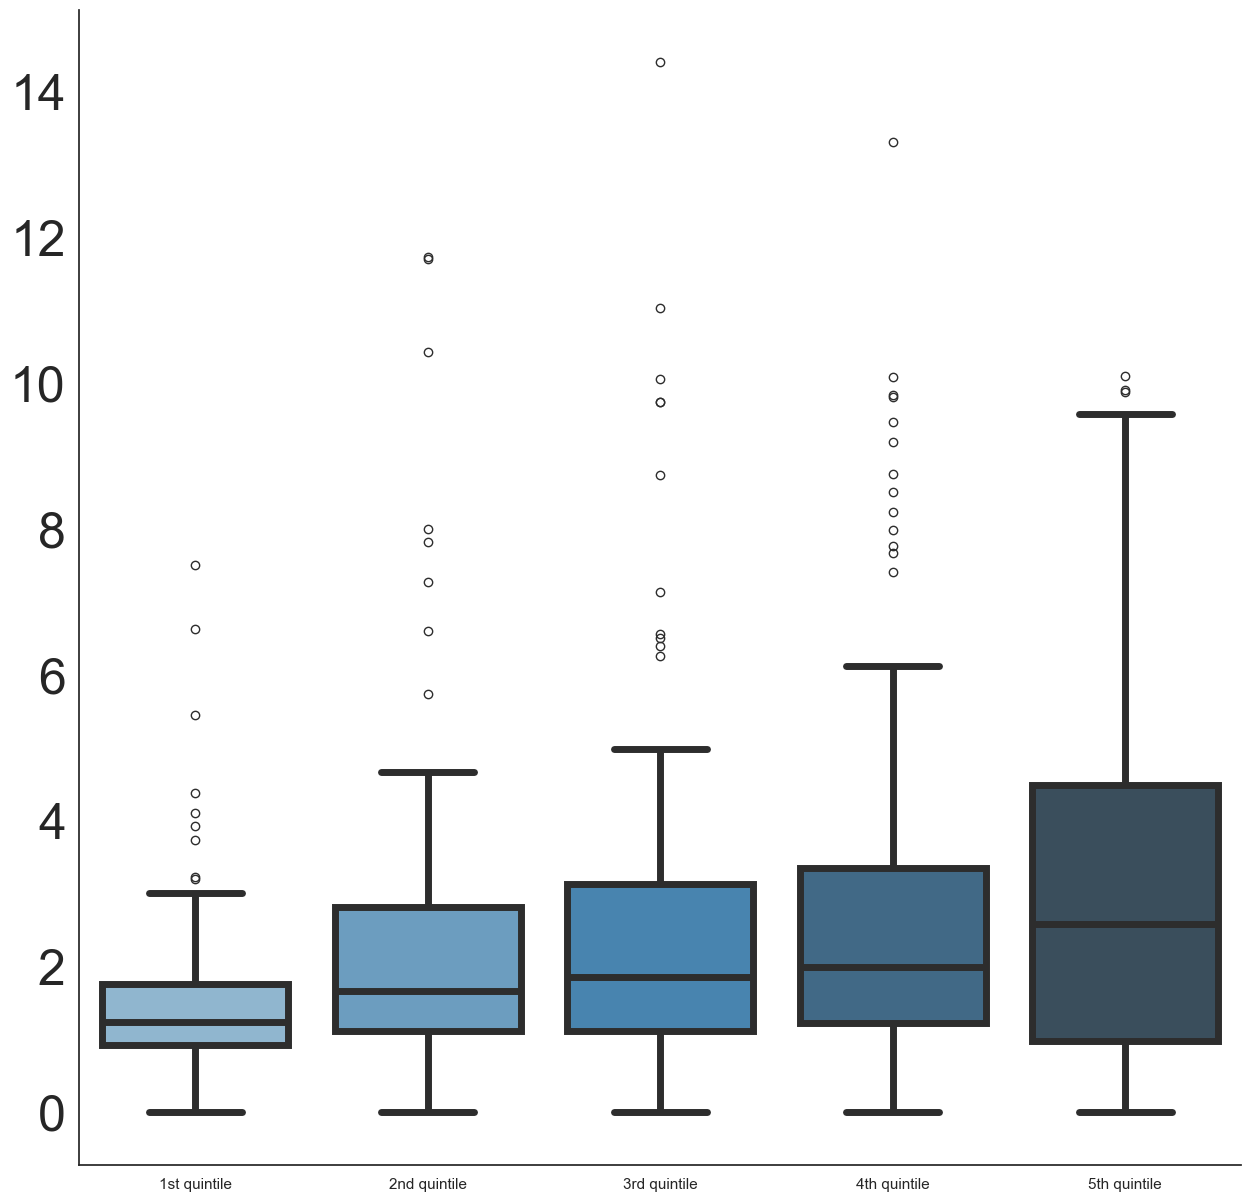

In [28]:
#Let's visualize as boxplot
import seaborn as sns
import matplotlib.pyplot as plt

# set a grey background (use sns.set_theme() if seaborn version 0.11.0 or above) 
fig, ax = plt.subplots(figsize=(15, 15))

sns.set_style('white')
sns.set(style="white",font_scale = 2)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
g=sns.boxplot(data=geneoverlap_resnik_df_sort_by_overlap,x="Group", y="Resnik",order=['1st quintile','2nd quintile', '3rd quintile','4th quintile',
 '5th quintile'],palette="Blues_d",linewidth=5)
plt.xlabel('',fontsize=22)
plt.ylabel('', fontsize=22)
#plt.xticks([], fontsize=22)
ax.grid(False)
ax.set_yticklabels([int(i) for i in ax.get_yticks()], size = 36)
#ax.set_xticklabels(ax.get_xticks(), size = 36)
#plt.savefig('output/Figures/SF7B_v03.pdf',format='pdf',dpi=300, bbox_inches = "tight")
#g.set_yscale("log")

plt.show()


In [29]:
print(scipy.stats.pearsonr(avg_overlap_in_com, avg_resnik_in_com))


PearsonRResult(statistic=0.23964871122900497, pvalue=4.692919164357374e-08)
